## 1. Importing Libraries

In [14]:
import os
import pandas as pd
import polars as pl 
import seaborn as sns 
import matplotlib.pyplot as plt 

## 2. Load Data using Polars

In [2]:
# Path
DATA_PATH = '../data/raw/spotify_data.csv'

# Load data with relevant columns for mood based recommender system
cols_to_keep = [
    "track_name", "artist_name", "genre", "year",
    "danceability", "energy", "key", "loudness", 
    "mode", "speechiness", "acousticness", "instrumentalness", 
    "liveness", "valence", "tempo", "duration_ms"
]

print("Loading Data...")
df = pl.read_csv(DATA_PATH, ignore_errors=True).select(cols_to_keep)

Loading Data...


In [3]:
df.head()

track_name,artist_name,genre,year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
str,str,str,i64,f64,f64,i64,f64,i64,f64,f64,f64,f64,f64,f64,i64
"""I Won't Give Up""","""Jason Mraz""","""acoustic""",2012,0.483,0.303,4,-10.058,1,0.0429,0.694,0.0,0.115,0.139,133.406,240166
"""93 Million Miles""","""Jason Mraz""","""acoustic""",2012,0.572,0.454,3,-10.286,1,0.0258,0.477,0.0000137,0.0974,0.515,140.182,216387
"""Do Not Let Me Go""","""Joshua Hyslop""","""acoustic""",2012,0.409,0.234,3,-13.711,1,0.0323,0.338,0.00005,0.0895,0.145,139.832,158960
"""Fast Car""","""Boyce Avenue""","""acoustic""",2012,0.392,0.251,10,-9.845,1,0.0363,0.807,0.0,0.0797,0.508,204.961,304293
"""Sky's Still Blue""","""Andrew Belle""","""acoustic""",2012,0.43,0.791,6,-5.419,0,0.0302,0.0726,0.0193,0.11,0.217,171.864,244320


In [4]:
df.shape

(1159764, 16)

In [6]:
df.glimpse()

Rows: 1159764
Columns: 16
$ track_name       <str> "I Won't Give Up", '93 Million Miles', 'Do Not Let Me Go', 'Fast Car', "Sky's Still Blue", 'What They Say', 'Walking in a Winter Wonderland', 'Dancing Shoes', 'Living in the Moment', 'Heaven'
$ artist_name      <str> 'Jason Mraz', 'Jason Mraz', 'Joshua Hyslop', 'Boyce Avenue', 'Andrew Belle', 'Chris Smither', 'Matt Wertz', 'Green River Ordinance', 'Jason Mraz', 'Boyce Avenue'
$ genre            <str> 'acoustic', 'acoustic', 'acoustic', 'acoustic', 'acoustic', 'acoustic', 'acoustic', 'acoustic', 'acoustic', 'acoustic'
$ year             <i64> 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012
$ danceability     <f64> 0.483, 0.572, 0.409, 0.392, 0.43, 0.566, 0.575, 0.586, 0.65, 0.619
$ energy           <f64> 0.303, 0.454, 0.234, 0.251, 0.791, 0.57, 0.606, 0.423, 0.628, 0.28
$ key              <i64> 4, 3, 3, 10, 6, 2, 9, 7, 7, 8
$ loudness         <f64> -10.058, -10.286, -13.711, -9.845, -5.419, -6.42, -8.197, -7.459, -7.16, -10.2

## 3. Data Cleaning

In [7]:
# Remove songs with missing values or 0 duration
df_clean = df.filter(
    (pl.col("duration_ms") > 30000) &  # Songs shorter than 30s are likely noise
    (pl.col("speechiness") < 0.66)     # Remove likely podcasts/spoken word
).drop_nulls()

print(f"Cleaned Data Shape: {df_clean.shape}")

Cleaned Data Shape: (1141126, 16)


## 4. EDA

Using Russell's Circumplex Model to map Valence (Positivity) and Energy (Intensity) to 4 Quadrants

1. First quadrant (High Valence, High Energy): Happy / Excited
2. Second quadrant (Low Valence, High Energy): Angry / Anxious
3. Third quadrant (Low Valence, Low Energy): Sad / Depressed
4. Fourth quadrant (High Valence, Low Energy): Calm / Relaxed

In [8]:
def get_mood_label(valence, energy):
    if valence >= 0.5 and energy >= 0.5:
        return "Happy/Energetic"
    elif valence < 0.5 and energy >= 0.5:
        return "Angry/Intense"
    elif valence < 0.5 and energy < 0.5:
        return "Sad/Melancholic"
    else: # valence >= 0.5 and energy < 0.5
        return "Calm/Relaxed"

In [9]:
df_mood = df_clean.with_columns(
    pl.when((pl.col("valence") >= 0.5) & (pl.col("energy") >= 0.5))
    .then(pl.lit("Happy"))
    .when((pl.col("valence") < 0.5) & (pl.col("energy") >= 0.5))
    .then(pl.lit("Angry"))
    .when((pl.col("valence") < 0.5) & (pl.col("energy") < 0.5))
    .then(pl.lit("Sad"))
    .otherwise(pl.lit("Calm"))
    .alias("mood_label")
)

In [16]:
# Save to Parquet
df_mood.write_parquet("../data/processed/songs_with_mood.parquet")
print("Saved processed data to 'data/processed/songs_with_mood.parquet'")

Saved processed data to 'data/processed/songs_with_mood.parquet'


For Visualization of Mood Map taking small sample data

In [12]:
sample_df = df_mood.sample(50000).to_pandas()

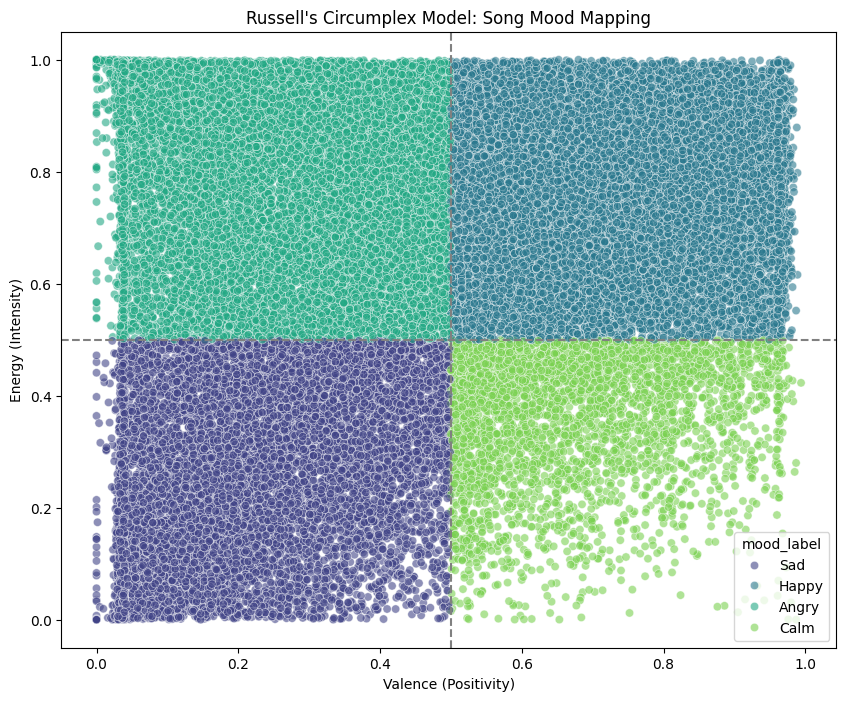

In [13]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=sample_df, 
    x="valence", 
    y="energy", 
    hue="mood_label", 
    palette="viridis",
    alpha=0.6
)
plt.axhline(0.5, color='gray', linestyle='--')
plt.axvline(0.5, color='gray', linestyle='--')
plt.title("Russell's Circumplex Model: Song Mood Mapping")
plt.xlabel("Valence (Positivity)")
plt.ylabel("Energy (Intensity)")
plt.show()

Inference - Above figure shows a distribution of mood and songs

In [15]:
pdf = df_mood.sample(10000).to_pandas()

Genre Validation to check genre and mood match

In [16]:
# Box plot
# Let's pick 4 distinct genres to see if they land in the right "Mood Quadrants"
target_genres = ['acoustic', 'death-metal', 'pop', 'classical'] 

subset = pdf[pdf['genre'].isin(target_genres)]

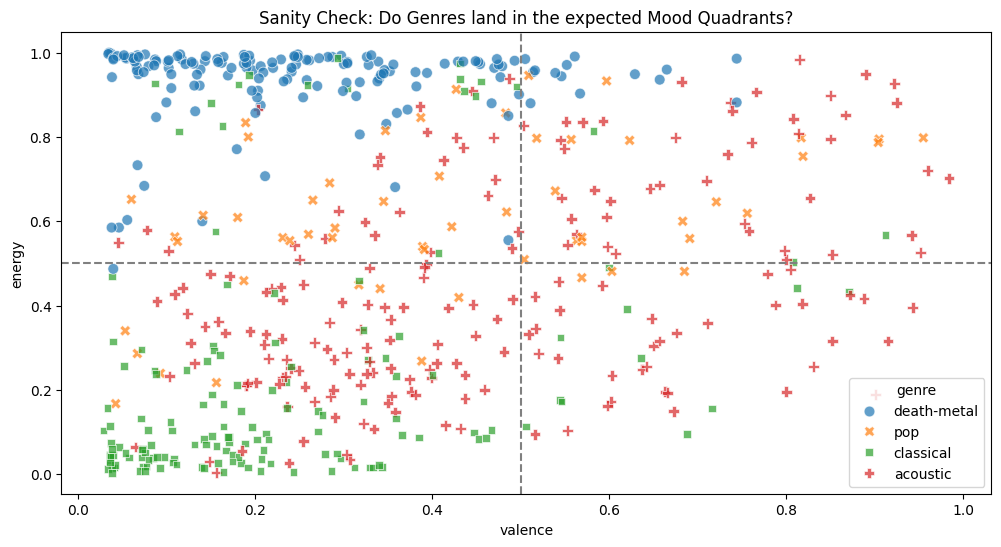

In [17]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=subset, x='valence', y='energy', hue='genre', style='genre', s=60, alpha=0.7)
plt.axhline(0.5, color='gray', linestyle='--')
plt.axvline(0.5, color='gray', linestyle='--')
plt.title("Sanity Check: Do Genres land in the expected Mood Quadrants?")
plt.show()

**Inference**

**Death Metal (Blue Circles):** They are tightly clustered in the Top-Left (High Energy, Low Valence).

**Interpretation:** Fast, loud, but "negative" emotion. This is exactly "Angry/Intense." 

**Classical (Green Squares):** They hug the bottom of the chart (Low Energy).

**Interpretation:** Classical music is dynamic, but Spotify's algorithm correctly identifies it as having lower average intensity than pop/metal. This maps to "Calm" or "Sad."

**Pop (Orange Xs):** Scattered everywhere. 

**Interpretation:** "Pop" isn't a sonic style; it's a popularity metric. A ballad (Sad) and a dance hit (Happy) are both "Pop." 

Correlation Matrix

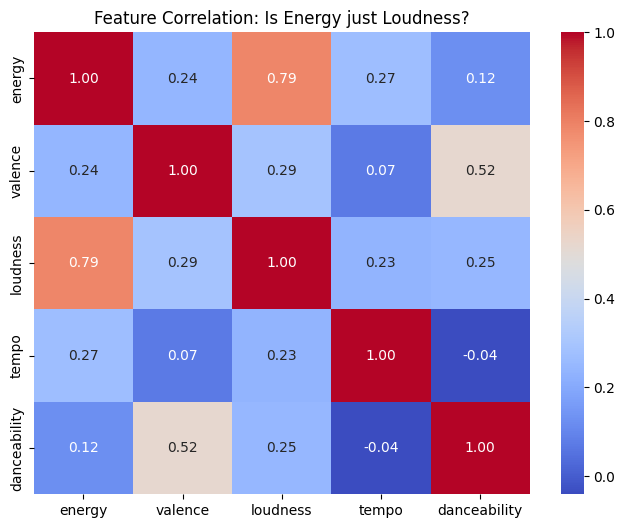

In [18]:
corr_cols = ['energy', 'valence', 'loudness', 'tempo', 'danceability']
corr_matrix = pdf[corr_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation: Is Energy just Loudness?")
plt.show()

**Energy vs. Loudness (0.79):** This is a very strong correlation.

**Insight:** Spotify's "Energy" calculation relies heavily on volume.

**Decision:** In the model, drop loudness. It is 80% redundant information. Keeping both might confuse the model (multicollinearity) without adding value. Keep energy as it is more holistic.

**Valence vs. Energy (0.24):** This is low, which is great.

**Insight:** It proves that "Happy" (Valence) is not the same as "Fast" (Energy). This justifies using the 2D Quadrant system